## Pre Adv Training

In [13]:
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
import numpy as np
import os

In [14]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [15]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

In [16]:
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

In [17]:
# load mnist dataset
ds_train_images = []
ds_train_labels = []

for images, labels in ds_train.unbatch():
  ds_train_images.append(images)
  ds_train_labels.append(labels)

ds_train_images = np.array(ds_train_images)
ds_train_labels = np.array(ds_train_labels)

In [18]:
# load mnist dataset
ds_test_images = []
ds_test_labels = []

for images, labels in ds_test.unbatch():
  ds_test_images.append(images)
  ds_test_labels.append(labels)

ds_test_images = np.array(ds_test_images)
ds_test_labels = np.array(ds_test_labels)

## Adv Training v1

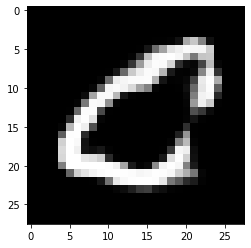

(94372, 28, 28, 1)
(94372,)


In [2]:
# load mnist_adv dataset
# adv_path = 'assets/data/mnist_adv/'
adv_path = 'mnist_zico_defense_by_attack_with_z0/'
adv_files = []
X = []
y = []

# for loop to load all the images
for source in range(10):
    for target in range(10):
        if(source != target):
          file = np.load(adv_path + 'from' + str(source) + 'to' + str(target) + '.npz')
          adv_files.append(file)
          y.extend(np.full(len(file['adv_imgs']), source).tolist())

keys = adv_files[0].files

for file in adv_files:
  with file as data:
      X.extend(data[keys[0]])

X = np.array(X)
y = np.array(y)
y_one_hot = np.take(np.eye(10), y, axis=0)

plt.imshow(X[0], cmap='gray')
plt.show()
print(X.shape)
print(y.shape)

In [8]:
y_one_hot

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [3]:
# split X into 70-30 train-test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [10]:
X_train.shape

(66060, 28, 28, 1)

In [11]:
X_test.shape

(28312, 28, 28, 1)

In [10]:
print(X_train.shape, ds_train_images.shape)

ds_train_adv_images = np.concatenate((ds_train_images, X_train), axis=0)
ds_train_adv_labels = np.concatenate((ds_train_labels, y_train), axis=0)

print(ds_train_adv_images.shape, ds_train_adv_labels.shape)


(66060, 28, 28, 1) (60000, 28, 28, 1)
(126060, 28, 28, 1) (126060,)


In [11]:
print(X_test.shape, ds_test_images.shape)

ds_test_adv_images = np.concatenate((ds_test_images, X_test), axis=0)
ds_test_adv_labels = np.concatenate((ds_test_labels, y_test), axis=0)

print(ds_test_adv_images.shape, ds_test_adv_labels.shape)


(28312, 28, 28, 1) (10000, 28, 28, 1)
(38312, 28, 28, 1) (38312,)


### Training and Saving Model on ACGAN Images

In [20]:
# model_adv = tf.keras.models.Sequential([
#   tf.keras.layers.Flatten(input_shape=(28, 28)),
#   tf.keras.layers.Dense(128, activation='relu'),
#   tf.keras.layers.Dense(10)
# ])

model_adv = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10)
])

model_adv.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model_adv.fit(
    x = ds_train_adv_images,
    y = ds_train_adv_labels,
    epochs=6,
    shuffle=True
)

Epoch 1/6
3940/3940 [==============================] - 30s 8ms/step - loss: 0.0915 - sparse_categorical_accuracy: 0.9729
Epoch 2/6
3940/3940 [==============================] - 29s 7ms/step - loss: 0.0307 - sparse_categorical_accuracy: 0.9912
Epoch 3/6
3940/3940 [==============================] - 29s 7ms/step - loss: 0.0182 - sparse_categorical_accuracy: 0.9946
Epoch 4/6
3940/3940 [==============================] - 29s 7ms/step - loss: 0.0119 - sparse_categorical_accuracy: 0.9964
Epoch 5/6
3940/3940 [==============================] - 30s 8ms/step - loss: 0.0087 - sparse_categorical_accuracy: 0.9972
Epoch 6/6
3940/3940 [==============================] - 29s 7ms/step - loss: 0.0060 - sparse_categorical_accuracy: 0.9979


In [13]:
# save model_adv
model_adv.save('assets/models/mnist_adv_model.h5')

In [14]:
# model = tf.keras.models.Sequential([
#   tf.keras.layers.Flatten(input_shape=(28, 28)),
#   tf.keras.layers.Dense(128, activation='relu'),
#   tf.keras.layers.Dense(10)
# ])

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10)
])


model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model.fit(
    ds_train,
    epochs=6,
    validation_data=ds_test,
    shuffle=True
)

Epoch 1/6
469/469 [==============================] - 6s 12ms/step - loss: 0.1744 - sparse_categorical_accuracy: 0.9471 - val_loss: 0.0621 - val_sparse_categorical_accuracy: 0.9799
Epoch 2/6
469/469 [==============================] - 5s 11ms/step - loss: 0.0533 - sparse_categorical_accuracy: 0.9836 - val_loss: 0.0615 - val_sparse_categorical_accuracy: 0.9788
Epoch 3/6
469/469 [==============================] - 5s 11ms/step - loss: 0.0330 - sparse_categorical_accuracy: 0.9902 - val_loss: 0.0505 - val_sparse_categorical_accuracy: 0.9836
Epoch 4/6
469/469 [==============================] - 6s 12ms/step - loss: 0.0215 - sparse_categorical_accuracy: 0.9938 - val_loss: 0.0444 - val_sparse_categorical_accuracy: 0.9857
Epoch 5/6
469/469 [==============================] - 5s 11ms/step - loss: 0.0156 - sparse_categorical_accuracy: 0.9954 - val_loss: 0.0462 - val_sparse_categorical_accuracy: 0.9850
Epoch 6/6
469/469 [==============================] - 5s 12ms/step - loss: 0.0116 - sparse_categorica

In [15]:
# save model
model.save('assets/models/mnist_model.h5')

## Adv Training v2

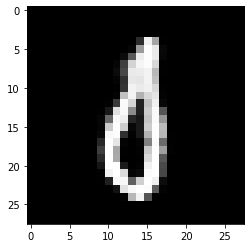

(94015, 28, 28, 1)
(94015,)


In [12]:
# load mnist_adv dataset
# adv_path = 'assets/data/mnist_adv/'
adv_path = 'mnist_zico_defense_by_attack_with_z2/'
adv_files = []
X_2 = []
y_2 = []

# for loop to load all the images
for source in range(10):
    for target in range(10):
        if(source != target):
          file = np.load(adv_path + 'from' + str(source) + 'to' + str(target) + '.npz')
          adv_files.append(file)
          y_2.extend(np.full(len(file['adv_imgs']), source).tolist())

keys = adv_files[0].files

for file in adv_files:
  with file as data:
      X_2.extend(data[keys[0]])

X_2 = np.array(X_2)
y_2 = np.array(y_2)
y_one_hot_2 = np.take(np.eye(10), y_2, axis=0)

plt.imshow(X_2[0], cmap='gray')
plt.show()
print(X_2.shape)
print(y_2.shape)

In [13]:
# split X into 70-30 train-test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_2, y_2, test_size=0.3, random_state=42)

In [14]:
X_train.shape

(65810, 28, 28, 1)

In [15]:
X_test.shape

(28205, 28, 28, 1)

In [16]:
print(X_train.shape, ds_train_images.shape)

ds_train_adv_images = np.concatenate((ds_train_images, X_train), axis=0)
ds_train_adv_labels = np.concatenate((ds_train_labels, y_train), axis=0)

print(ds_train_adv_images.shape, ds_train_adv_labels.shape)


(65810, 28, 28, 1) (60000, 28, 28, 1)
(125810, 28, 28, 1) (125810,)


In [17]:
print(X_test.shape, ds_test_images.shape)

ds_test_adv_images = np.concatenate((ds_test_images, X_test), axis=0)
ds_test_adv_labels = np.concatenate((ds_test_labels, y_test), axis=0)

print(ds_test_adv_images.shape, ds_test_adv_labels.shape)


(28205, 28, 28, 1) (10000, 28, 28, 1)
(38205, 28, 28, 1) (38205,)


In [18]:
# model_adv = tf.keras.models.Sequential([
#   tf.keras.layers.Flatten(input_shape=(28, 28)),
#   tf.keras.layers.Dense(128, activation='relu'),
#   tf.keras.layers.Dense(10)
# ])

model_adv_v2 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10)
])

model_adv_v2.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model_adv_v2.fit(
    x = ds_train_adv_images,
    y = ds_train_adv_labels,
    epochs=6,
    shuffle=True
)

Epoch 1/6
3932/3932 [==============================] - 117s 27ms/step - loss: 0.1904 - sparse_categorical_accuracy: 0.9385
Epoch 2/6
3932/3932 [==============================] - 47s 12ms/step - loss: 0.0767 - sparse_categorical_accuracy: 0.9760
Epoch 3/6
3932/3932 [==============================] - 26s 7ms/step - loss: 0.0503 - sparse_categorical_accuracy: 0.9839
Epoch 4/6
3932/3932 [==============================] - 26s 7ms/step - loss: 0.0342 - sparse_categorical_accuracy: 0.9885
Epoch 5/6
3932/3932 [==============================] - 26s 7ms/step - loss: 0.0248 - sparse_categorical_accuracy: 0.9913: 0s - loss: 0.0248 - sparse_categorical_acc
Epoch 6/6
3932/3932 [==============================] - 26s 7ms/step - loss: 0.0185 - sparse_categorical_accuracy: 0.9937: 1s - loss: 0.0185 - sparse_categ


In [19]:
# save model_adv
model_adv_v2.save('assets/models/mnist_adv_model_v2.h5')

## Adv Training v3

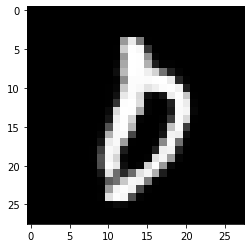

(11472, 28, 28, 1)
(11472,)


In [6]:
# load mnist_adv dataset
# adv_path = 'assets/data/mnist_adv/'
adv_path = 'mnist_zico_defense_by_attack_with_z3/'
adv_files = []
X_3 = []
y_3 = []

# for loop to load all the images
for source in range(10):
    for target in range(10):
        if(source != target):
          file = np.load(adv_path + 'from' + str(source) + 'to' + str(target) + '.npz')
          adv_files.append(file)
          y_3.extend(np.full(len(file['adv_imgs']), source).tolist())

keys = adv_files[0].files

for file in adv_files:
  with file as data:
      X_3.extend(data[keys[0]])

X_3 = np.array(X_3)
y_3 = np.array(y_3)
y_one_hot_2 = np.take(np.eye(10), y_3, axis=0)

plt.imshow(X_3[0], cmap='gray')
plt.show()
print(X_3.shape)
print(y_3.shape)

In [7]:
# split X into 70-30 train-test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_3, y_3, test_size=0.3, random_state=42)

In [14]:
print(X_train.shape, ds_train_images.shape)

ds_train_adv_images = np.concatenate((ds_train_images, X_train), axis=0)
ds_train_adv_labels = np.concatenate((ds_train_labels, y_train), axis=0)

print(ds_train_adv_images.shape, ds_train_adv_labels.shape)


(8030, 28, 28, 1) (60000, 28, 28, 1)
(68030, 28, 28, 1) (68030,)


In [15]:
print(X_test.shape, ds_test_images.shape)

ds_test_adv_images = np.concatenate((ds_test_images, X_test), axis=0)
ds_test_adv_labels = np.concatenate((ds_test_labels, y_test), axis=0)

print(ds_test_adv_images.shape, ds_test_adv_labels.shape)


(3442, 28, 28, 1) (10000, 28, 28, 1)
(13442, 28, 28, 1) (13442,)


In [16]:
# model_adv = tf.keras.models.Sequential([
#   tf.keras.layers.Flatten(input_shape=(28, 28)),
#   tf.keras.layers.Dense(128, activation='relu'),
#   tf.keras.layers.Dense(10)
# ])

model_adv_v3 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10)
])

model_adv_v3.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model_adv_v3.fit(
    x = ds_train_adv_images,
    y = ds_train_adv_labels,
    epochs=6,
    shuffle=True
)

Epoch 1/6
2126/2126 [==============================] - 57s 26ms/step - loss: 0.1428 - sparse_categorical_accuracy: 0.9570
Epoch 2/6
2126/2126 [==============================] - 53s 25ms/step - loss: 0.0485 - sparse_categorical_accuracy: 0.9853
Epoch 3/6
2126/2126 [==============================] - 51s 24ms/step - loss: 0.0307 - sparse_categorical_accuracy: 0.9908
Epoch 4/6
2126/2126 [==============================] - 41s 19ms/step - loss: 0.0199 - sparse_categorical_accuracy: 0.9937
Epoch 5/6
2126/2126 [==============================] - 14s 7ms/step - loss: 0.0135 - sparse_categorical_accuracy: 0.9956
Epoch 6/6
2126/2126 [==============================] - 14s 7ms/step - loss: 0.0109 - sparse_categorical_accuracy: 0.9963: 2s - loss: 0.


In [17]:
# save model_adv
model_adv_v3.save('assets/models/mnist_adv_model_v3.h5')

## Adv Training v3 boosted

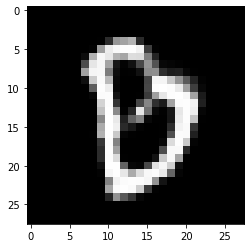

(95442, 28, 28, 1)
(95442,)


In [7]:
# load mnist_adv dataset
# adv_path = 'assets/data/mnist_adv/'
adv_path = 'mnist_zico_defense_by_attack_with_z4/'
adv_files = []
X_4 = []
y_4 = []

# for loop to load all the images
for source in range(10):
    for target in range(10):
        if(source != target):
          file = np.load(adv_path + 'from' + str(source) + 'to' + str(target) + '.npz')
          adv_files.append(file)
          y_4.extend(np.full(len(file['adv_imgs']), source).tolist())

keys = adv_files[0].files

for file in adv_files:
  with file as data:
      X_4.extend(data[keys[0]])

X_4 = np.array(X_4)
y_4 = np.array(y_4)
y_one_hot_2 = np.take(np.eye(10), y_4, axis=0)

plt.imshow(X_4[0], cmap='gray')
plt.show()
print(X_4.shape)
print(y_4.shape)

In [8]:
# split X into 70-30 train-test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_4, y_4, test_size=0.3, random_state=42)

In [9]:
print(X_train.shape, ds_train_images.shape)

ds_train_adv_images = np.concatenate((ds_train_images, X_train), axis=0)
ds_train_adv_labels = np.concatenate((ds_train_labels, y_train), axis=0)

print(ds_train_adv_images.shape, ds_train_adv_labels.shape)


(66809, 28, 28, 1) (60000, 28, 28, 1)
(126809, 28, 28, 1) (126809,)


In [10]:
print(X_test.shape, ds_test_images.shape)

ds_test_adv_images = np.concatenate((ds_test_images, X_test), axis=0)
ds_test_adv_labels = np.concatenate((ds_test_labels, y_test), axis=0)

print(ds_test_adv_images.shape, ds_test_adv_labels.shape)


(28633, 28, 28, 1) (10000, 28, 28, 1)
(38633, 28, 28, 1) (38633,)


In [11]:
# model_adv = tf.keras.models.Sequential([
#   tf.keras.layers.Flatten(input_shape=(28, 28)),
#   tf.keras.layers.Dense(128, activation='relu'),
#   tf.keras.layers.Dense(10)
# ])

model_adv_v3_2 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10)
])

model_adv_v3_2.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model_adv_v3_2.fit(
    x = ds_train_adv_images,
    y = ds_train_adv_labels,
    epochs=6,
    shuffle=True
)

Epoch 1/6
3963/3963 [==============================] - 119s 28ms/step - loss: 0.1041 - sparse_categorical_accuracy: 0.9700
Epoch 2/6
3963/3963 [==============================] - 102s 26ms/step - loss: 0.0323 - sparse_categorical_accuracy: 0.9911
Epoch 3/6
3963/3963 [==============================] - 100s 25ms/step - loss: 0.0209 - sparse_categorical_accuracy: 0.9937
Epoch 4/6
3963/3963 [==============================] - 100s 25ms/step - loss: 0.0143 - sparse_categorical_accuracy: 0.9955
Epoch 5/6
3963/3963 [==============================] - 91s 23ms/step - loss: 0.0098 - sparse_categorical_accuracy: 0.9969 0s - loss: 0.0098 - sparse_categorical_accuracy: 0.996
Epoch 6/6
3963/3963 [==============================] - 100s 25ms/step - loss: 0.0073 - sparse_categorical_accuracy: 0.9976


In [12]:
# save model_adv
model_adv_v3_2.save('assets/models/mnist_adv_model_v3_2.h5')

## Adv Training v4

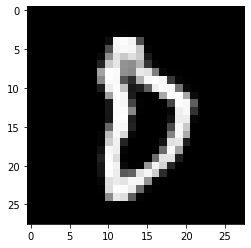

(11416, 28, 28, 1)
(11416,)


In [19]:
# load mnist_adv dataset
# adv_path = 'assets/data/mnist_adv/'
adv_path = 'mnist_zico_defense_by_attack_with_z5/'
adv_files = []
X_5 = []
y_5 = []

# for loop to load all the images
for source in range(10):
    for target in range(10):
        if(source != target):
          file = np.load(adv_path + 'from' + str(source) + 'to' + str(target) + '.npz')
          adv_files.append(file)
          y_5.extend(np.full(len(file['adv_imgs']), source).tolist())

keys = adv_files[0].files

for file in adv_files:
  with file as data:
      X_5.extend(data[keys[0]])

X_5 = np.array(X_5)
y_5 = np.array(y_5)
y_one_hot_2 = np.take(np.eye(10), y_5, axis=0)

plt.imshow(X_5[0], cmap='gray')
plt.show()
print(X_5.shape)
print(y_5.shape)

In [20]:
# split X into 70-30 train-test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_4, y_4, test_size=0.3, random_state=42)

In [21]:
print(X_train.shape, ds_train_images.shape)

ds_train_adv_images = np.concatenate((ds_train_images, X_train), axis=0)
ds_train_adv_labels = np.concatenate((ds_train_labels, y_train), axis=0)

print(ds_train_adv_images.shape, ds_train_adv_labels.shape)


(66809, 28, 28, 1) (60000, 28, 28, 1)
(126809, 28, 28, 1) (126809,)


In [22]:
print(X_test.shape, ds_test_images.shape)

ds_test_adv_images = np.concatenate((ds_test_images, X_test), axis=0)
ds_test_adv_labels = np.concatenate((ds_test_labels, y_test), axis=0)

print(ds_test_adv_images.shape, ds_test_adv_labels.shape)


(28633, 28, 28, 1) (10000, 28, 28, 1)
(38633, 28, 28, 1) (38633,)


In [23]:
# model_adv = tf.keras.models.Sequential([
#   tf.keras.layers.Flatten(input_shape=(28, 28)),
#   tf.keras.layers.Dense(128, activation='relu'),
#   tf.keras.layers.Dense(10)
# ])

model_adv_v4 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10)
])

model_adv_v4.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model_adv_v4.fit(
    x = ds_train_adv_images,
    y = ds_train_adv_labels,
    epochs=6,
    shuffle=True
)

Epoch 1/6
3963/3963 [==============================] - 86s 21ms/step - loss: 0.0946 - sparse_categorical_accuracy: 0.9717
Epoch 2/6
3963/3963 [==============================] - 27s 7ms/step - loss: 0.0310 - sparse_categorical_accuracy: 0.9910
Epoch 3/6
3963/3963 [==============================] - 27s 7ms/step - loss: 0.0186 - sparse_categorical_accuracy: 0.9946
Epoch 4/6
3963/3963 [==============================] - 27s 7ms/step - loss: 0.0116 - sparse_categorical_accuracy: 0.9963
Epoch 5/6
3963/3963 [==============================] - 27s 7ms/step - loss: 0.0090 - sparse_categorical_accuracy: 0.9972
Epoch 6/6
3963/3963 [==============================] - 27s 7ms/step - loss: 0.0065 - sparse_categorical_accuracy: 0.9979


In [24]:
# save model_adv
model_adv_v4.save('assets/models/mnist_adv_model_v4.h5')

## Load mnist_adv_model and mnist_model from local

In [18]:
# load model
model = tf.keras.models.load_model('assets/models/mnist_model.h5')

# load model_adv
model_adv = tf.keras.models.load_model('assets/models/mnist_adv_model.h5')

# load model_adv_v2
model_adv_v2 = tf.keras.models.load_model('assets/models/mnist_adv_model_v2.h5')

# load model_adv_v3
model_adv_v3 = tf.keras.models.load_model('assets/models/mnist_adv_model_v3.h5')

# load model_adv_v3_2
model_adv_v3_2 = tf.keras.models.load_model('assets/models/mnist_adv_model_v3_2.h5')

# load model_adv_v4
model_adv_v4 = tf.keras.models.load_model('assets/models/mnist_adv_model_v4.h5')

# load model_madry
model_madry = tf.keras.models.load_model('assets/models/mnist_model_madry.h5')

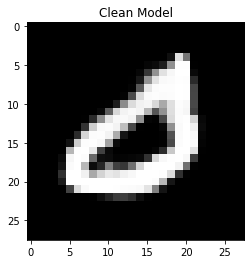

original label:  0
predicted label 0


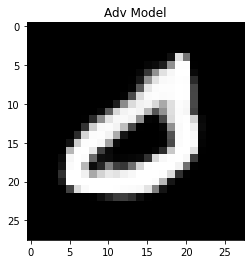

original label:  0
predicted label 0


In [30]:
random_index = np.random.randint(X.shape[0])

pixels = X[random_index].reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.title('Clean Model')
plt.show()
print('original label: ', y[random_index])
print('predicted label', np.argmax(model.predict(np.array([X[random_index]]))))

plt.imshow(pixels, cmap='gray')
plt.title('Adv Model')
plt.show()
print('original label: ', y[random_index])
print('predicted label', np.argmax(model_adv.predict(np.array([X[random_index]]))))

In [22]:
X_test.shape

(28205, 28, 28, 1)

In [23]:
y_test.shape

(28205,)

In [27]:
print('model_adv accuracy on adv images: ', model_adv.evaluate(X_test, y_test, verbose=2)[1])
print('model_adv_v2 accuracy on adv images: ', model_adv_v2.evaluate(X_test, y_test, verbose=2)[1])
print('model_adv_v2 accuracy on adv images: ', model_adv_v3.evaluate(X_test, y_test, verbose=2)[1])
print('model accuracy on adv images: ',  model.evaluate(X_test, y_test, verbose=2)[1])
print('model_madry accuracy on adv images: ',  model_madry.evaluate(X_test, y_test, verbose=2)[1])

882/882 - 10s - loss: 0.3295 - sparse_categorical_accuracy: 0.9010 - 10s/epoch - 11ms/step
model_adv accuracy on adv images:  0.9010459184646606
882/882 - 10s - loss: 0.0933 - sparse_categorical_accuracy: 0.9717 - 10s/epoch - 11ms/step
model_adv_v2 accuracy on adv images:  0.9717071652412415
882/882 - 5s - loss: 0.9106 - sparse_categorical_accuracy: 0.7054 - 5s/epoch - 6ms/step
model accuracy on adv images:  0.7054423093795776
882/882 - 3s - loss: 1.2243 - sparse_categorical_accuracy: 0.5954 - 3s/epoch - 3ms/step
model_madry accuracy on adv images:  0.5953554511070251


In [28]:
print('model_adv accuracy on clean test images: ', model_adv.evaluate(ds_test, verbose=2)[1])
print('model_adv_v2 accuracy on clean test images: ', model_adv_v2.evaluate(ds_test, verbose=2)[1])
print('model_adv_v2 accuracy on adv images: ', model_adv_v3.evaluate(ds_test, verbose=2)[1])
print('model accuracy on clean test images: ', model.evaluate(ds_test, verbose=2)[1])
print('model_madry accuracy on clean test images: ',  model_madry.evaluate(ds_test, verbose=2)[1])

79/79 [==============================] - 2s 23ms/step - loss: 0.0572 - sparse_categorical_accuracy: 0.9858
model_adv accuracy on clean test images:  0.98580002784729
79/79 [==============================] - 2s 24ms/step - loss: 0.0770 - sparse_categorical_accuracy: 0.9858
model_adv_v2 accuracy on clean test images:  0.98580002784729
79/79 [==============================] - 2s 24ms/step - loss: 0.0471 - sparse_categorical_accuracy: 0.9850
model accuracy on clean test images:  0.9850000143051147
79/79 [==============================] - 2s 25ms/step - loss: 0.1927 - sparse_categorical_accuracy: 0.9360
model_madry accuracy on clean test images:  0.9359999895095825


## Generate adversarial images on mnist using cleverhans

In [22]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images / 255.0
test_images = test_images / 255.0

num_classes = 10

model_cleverhans = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Activation(tf.nn.softmax) # We seperate the activation layer to be able to access the logits of the previous layer later
])

model_cleverhans.compile(optimizer='adam',
              loss= 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_cleverhans.fit(train_images, train_labels, epochs=10, validation_split=0.2)
test_loss, test_acc = model_cleverhans.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

Epoch 1/10
1500/1500 [==============================] - 11s 7ms/step - loss: 0.1599 - accuracy: 0.9505 - val_loss: 0.0711 - val_accuracy: 0.9797
Epoch 2/10
1500/1500 [==============================] - 10s 7ms/step - loss: 0.0516 - accuracy: 0.9840 - val_loss: 0.0586 - val_accuracy: 0.9827
Epoch 3/10
1500/1500 [==============================] - 10s 6ms/step - loss: 0.0289 - accuracy: 0.9905 - val_loss: 0.0650 - val_accuracy: 0.9812
Epoch 4/10
1500/1500 [==============================] - 10s 6ms/step - loss: 0.0191 - accuracy: 0.9938 - val_loss: 0.0618 - val_accuracy: 0.9828
Epoch 5/10
1500/1500 [==============================] - 10s 6ms/step - loss: 0.0134 - accuracy: 0.9958 - val_loss: 0.0586 - val_accuracy: 0.9847
Epoch 6/10
1500/1500 [==============================] - 10s 6ms/step - loss: 0.0091 - accuracy: 0.9968 - val_loss: 0.0584 - val_accuracy: 0.9852
Epoch 7/10
1500/1500 [==============================] - 10s 6ms/step - loss: 0.0081 - accuracy: 0.9974 - val_loss: 0.0692 - val_ac

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 5408)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               692352    
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 693,962
Trainable params: 693,962
Non-trainable params: 0
________________________________________________

In [24]:
model_adv.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 128)               692352    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 693,962
Trainable params: 693,962
Non-trainable params: 0
__________________________________________________

In [25]:
model_cleverhans.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 5408)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               692352    
                                                                 
 dense_5 (Dense)             (None, 10)                1290      
                                                                 
 activation (Activation)     (None, 10)                0         
                                                      

In [26]:
import cleverhans

### FGSM Against Clean and Adversarially Trained Model

In [27]:
# Import the attack
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method

#The attack requires the model to ouput the logits
logits_model = tf.keras.Model(model.input,model.layers[-1].output)

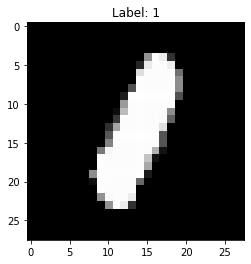

In [28]:
random_index = np.random.randint(test_images.shape[0])

original_image = test_images[random_index]
original_image = tf.convert_to_tensor(original_image.reshape((1,28,28))) #The .reshape just gives it the proper form to input into the model, a batch of 1 a.k.a a tensor

original_label = test_labels[random_index]
original_label = np.reshape(original_label, (1,)).astype('int64') # Give label proper shape and type for cleverhans

#Show the image
plt.figure()
plt.grid(False)

plt.imshow(np.reshape(original_image, (28,28)), cmap='gray')
plt.title("Label: {}".format(original_label[0]))

plt.show()

Clean Model Prediction: 1
Adv Model Prediction: 1


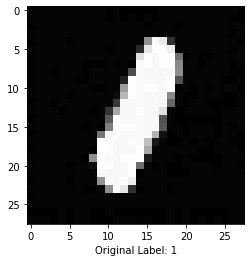

In [34]:
epsilon = 0.01

adv_example_untargeted_label = fast_gradient_method(logits_model, original_image, epsilon, np.inf, targeted=False)

adv_example_untargeted_label_pred = model.predict(adv_example_untargeted_label)
adv_example_untargeted_label_pred_adv_model = model_adv.predict(adv_example_untargeted_label)

print("Clean Model Prediction: {}".format(np.argmax(adv_example_untargeted_label_pred)))
print("Adv Model Prediction: {}".format(np.argmax(adv_example_untargeted_label_pred_adv_model)))

#Show the image
plt.figure()
plt.grid(False)

plt.imshow(np.reshape(adv_example_untargeted_label, (28,28)), cmap='gray')
# plt.title("Model Prediction: {}".format(np.argmax(adv_example_untargeted_label_pred)))
plt.xlabel("Original Label: {}".format(original_label[0]))

plt.show()

Clean Model Prediction: 1
Adv Model Prediction: 1


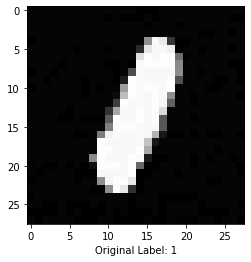

In [35]:
epsilon = 0.01
# The target value may have to be changed to work, some images are more easily missclassified as different labels
target = 9

target_label = np.reshape(target, (1,)).astype('int64') # Give target label proper size and dtype to feed through

adv_example_targeted_label = fast_gradient_method(logits_model, original_image, epsilon, np.inf, y=target_label, targeted=True)

adv_example_targeted_label_pred = model.predict(adv_example_targeted_label)
adv_example_targeted_label_pred_adv_model = model_adv.predict(adv_example_targeted_label)

print("Clean Model Prediction: {}".format(np.argmax(adv_example_targeted_label_pred)))
print("Adv Model Prediction: {}".format(np.argmax(adv_example_targeted_label_pred_adv_model)))


#Show the image
plt.figure()
plt.grid(False)

plt.imshow(np.reshape(adv_example_targeted_label, (28,28)), cmap='gray')
# plt.title("Model Prediction: {}".format(np.argmax(adv_example_targeted_label_pred)))
plt.xlabel("Original Label: {}".format(original_label[0]))

plt.show()

#### Generate FGSM adv mnist dataset

In [67]:
# calculate error rate for FGSM attack on both clean and adv model with varying epsilon values

# iterate from 0.1 to 1.5 with 0.1 step size
epsilon_values = np.arange(0.1, 1.5, 0.1)
fgsm_images = []
fgsm_labels = []
model_adv_missclassifications = np.arange(0, len(epsilon_values))
model_missclassifications = np.arange(0, len(epsilon_values))


for index, epsilon in enumerate(epsilon_values):
    print(epsilon)

    # original image and original label

    for i in range(test_images.shape[0]):

        original_image = test_images[i]
        original_image = tf.convert_to_tensor(original_image.reshape((1,28,28))) #The .reshape just gives it the proper form to input into the model, a batch of 1 a.k.a a tensor

        original_label = test_labels[i]
        original_label = np.reshape(original_label, (1,)).astype('int64') # Give label proper shape and type for cleverhans

        adv_example_untargeted_label = fast_gradient_method(logits_model, original_image, epsilon, np.inf, targeted=False)

        # adv_example_untargeted_label_pred = model.predict(adv_example_untargeted_label)
        # adv_example_untargeted_label_pred_adv_model = model_adv.predict(adv_example_untargeted_label)
        
        # add fgsm image to list
        fgsm_images.append(adv_example_untargeted_label)
        fgsm_labels.append(original_label)

        # if np.argmax(adv_example_untargeted_label_pred) != original_label[0]:
        #     model_missclassifications[index] += 1
        # if np.argmax(adv_example_untargeted_label_pred_adv_model) != original_label[0]:
        #     model_adv_missclassifications[index] += 1
        
    
print(model_missclassifications)
print(model_adv_missclassifications)

np.savez('fgsm_images', images=fgsm_images, labels=fgsm_labels)

0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7000000000000001
0.8
0.9
1.0
1.1
1.2000000000000002
1.3000000000000003
1.4000000000000001
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]


### PGD Against Clean and Adversarially Trained Model

In [36]:
# Import the attack
from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent

#The attack requires the model to ouput the logits
logits_model = tf.keras.Model(model.input,model.layers[-1].output)

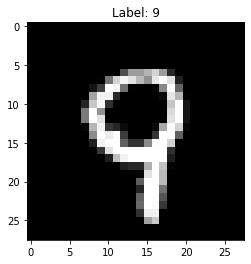

In [37]:
random_index = np.random.randint(test_images.shape[0])

original_image = test_images[random_index]
original_image = tf.convert_to_tensor(original_image.reshape((1,28,28)), dtype=tf.float32) #The .reshape just gives it the proper form to input into the model, a batch of 1 a.k.a a tensor

original_label = test_labels[random_index]
original_label = np.reshape(original_label, (1,)).astype('int64') # Give label proper shape and type for cleverhans

#Show the image
plt.figure()
plt.grid(False)

plt.imshow(np.reshape(original_image, (28,28)), cmap='gray')
plt.title("Label: {}".format(original_label[0]))

plt.show()

Clean Model Prediction: 4
Adv Model Prediction: 9


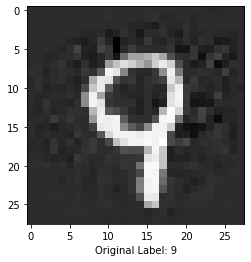

In [39]:
epsilon = 1.0

adv_example_untargeted_label = projected_gradient_descent(model_fn=logits_model, x=original_image, eps=epsilon, eps_iter=0.01, targeted=False, nb_iter=200, norm=2)

adv_example_untargeted_label_pred = model.predict(adv_example_untargeted_label)
adv_example_untargeted_label_pred_adv_model = model_adv.predict(adv_example_untargeted_label)

print("Clean Model Prediction: {}".format(np.argmax(adv_example_untargeted_label_pred)))
print("Adv Model Prediction: {}".format(np.argmax(adv_example_untargeted_label_pred_adv_model)))

#Show the image
plt.figure()
plt.grid(False)

plt.imshow(np.reshape(adv_example_untargeted_label, (28,28)), cmap='gray')
# plt.title("Model Prediction: {}".format(np.argmax(adv_example_untargeted_label_pred)))
plt.xlabel("Original Label: {}".format(original_label[0]))

plt.show()

Clean Model Prediction: 2
Adv Model Prediction: 9


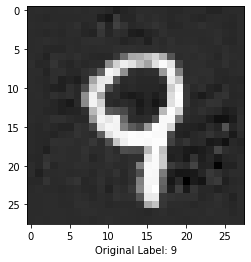

In [46]:
epsilon = 0.9
# The target value may have to be changed to work, some images are more easily missclassified as different labels
target = 2

target_label = np.reshape(target, (1,)).astype('int64') # Give target label proper size and dtype to feed through

adv_example_targeted_label = projected_gradient_descent(model_fn=logits_model, x=original_image, eps=epsilon, eps_iter=0.1, nb_iter=200, norm=2, y=target_label, targeted=True)

adv_example_targeted_label_pred = model.predict(adv_example_targeted_label)
adv_example_targeted_label_pred_adv_model = model_adv.predict(adv_example_targeted_label)

print("Clean Model Prediction: {}".format(np.argmax(adv_example_targeted_label_pred)))
print("Adv Model Prediction: {}".format(np.argmax(adv_example_targeted_label_pred_adv_model)))


#Show the image
plt.figure()
plt.grid(False)

plt.imshow(np.reshape(adv_example_targeted_label, (28,28)), cmap='gray')
# plt.title("Model Prediction: {}".format(np.argmax(adv_example_targeted_label_pred)))
plt.xlabel("Original Label: {}".format(original_label[0]))

plt.show()

#### Generate PGD adv mnist dataset

In [69]:
# calculate error rate for PGD attack on both clean and adv model with varying epsilon values

# iterate from 0.1 to 1.5 with 0.1 step size
epsilon_values = np.arange(0.1, 1.5, 0.1)
pgd_images = []
pgd_labels = []
model_adv_missclassifications = np.arange(0, len(epsilon_values))
model_missclassifications = np.arange(0, len(epsilon_values))

for index, epsilon in enumerate(epsilon_values):
    print(epsilon)

    # original image and original label

    for i in range(test_images.shape[0]):

        original_image = test_images[i]
        original_image = tf.convert_to_tensor(original_image.reshape((1,28,28)), dtype=tf.float32) #The .reshape just gives it the proper form to input into the model, a batch of 1 a.k.a a tensor

        original_label = test_labels[i]
        original_label = np.reshape(original_label, (1,)).astype('int64') # Give label proper shape and type for cleverhans

        adv_example_untargeted_label = projected_gradient_descent(model_fn=logits_model, x=original_image, eps=epsilon, eps_iter=0.01, targeted=False, nb_iter=200, norm=2)

        # adv_example_untargeted_label_pred = model.predict(adv_example_untargeted_label)
        # adv_example_untargeted_label_pred_adv_model = model_adv.predict(adv_example_untargeted_label)
        
        # add pgd image to list
        pgd_images.append(adv_example_untargeted_label)
        pgd_labels.append(original_label)

        # if np.argmax(adv_example_untargeted_label_pred) != original_label[0]:
        #     model_missclassifications[index] += 1
        # if np.argmax(adv_example_untargeted_label_pred_adv_model) != original_label[0]:
        #     model_adv_missclassifications[index] += 1
        
    
print(model_missclassifications)
print(model_adv_missclassifications)

np.savez('pgd_images', images=pgd_images, labels=pgd_labels)


0.1


## Run benchmarks against Madry's Adversarial MNIST Classifier

In [19]:
# import fgsm and pgd adversarial sampels
pgd_images = np.load('pgd_images.npz')['images']
pgd_labels = np.load('pgd_images.npz')['labels']

fgsm_images = np.load('fgsm_images.npz')['images']
fgsm_labels = np.load('fgsm_images.npz')['labels']

# reshape pgd and fgsm images to 28, 28, 1
pgd_images = np.reshape(pgd_images, (len(pgd_images), 28, 28, 1))
fgsm_images = np.reshape(fgsm_images, (len(fgsm_images), 28, 28, 1))

print(pgd_images.shape)
print(pgd_labels.shape)
print(fgsm_images.shape)
print(fgsm_labels.shape)

(140000, 28, 28, 1)
(140000, 1)
(140000, 28, 28, 1)
(140000, 1)


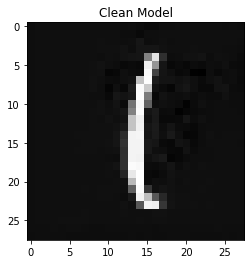

original label:  [1]
predicted label 1


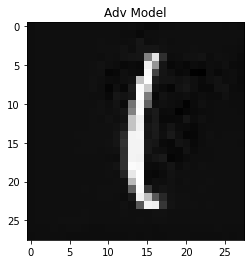

original label:  [1]
predicted label 1


In [42]:
random_index = np.random.randint(pgd_images.shape[0])

pixels = pgd_images[random_index].reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.title('Clean Model')
plt.show()
print('original label: ', pgd_labels[random_index])
print('predicted label', np.argmax(model.predict(np.array([pgd_images[random_index]]))))

plt.imshow(pixels, cmap='gray')
plt.title('Adv Model')
plt.show()
print('original label: ', pgd_labels[random_index])
print('predicted label', np.argmax(model_adv.predict(np.array([pgd_images[random_index]]))))

In [7]:
def evalugate_pgd():
    print('model_adv accuracy on Cleverhans PGD images: ', model_adv.evaluate(pgd_images, pgd_labels, verbose=2)[1])
    print('model_adv_2 accuracy on Cleverhans PGD images: ', model_adv_v2.evaluate(pgd_images, pgd_labels, verbose=2)[1])
    print('model accuracy on  Cleverhans PGD images: ',  model.evaluate(pgd_images, pgd_labels, verbose=2)[1])
    print('model_madry accuracy on  Cleverhans PGD images: ',  model_madry.evaluate(pgd_images, pgd_labels, verbose=2)[1])

evalugate_pgd()

4375/4375 - 46s - loss: 0.9081 - sparse_categorical_accuracy: 0.8574 - 46s/epoch - 10ms/step
model_adv accuracy on Cleverhans PGD images:  0.8573571443557739
4375/4375 - 44s - loss: 1.7685 - sparse_categorical_accuracy: 0.7878 - 44s/epoch - 10ms/step
model_adv_2 accuracy on Cleverhans PGD images:  0.7877500057220459


In [4]:
def evaluate_fgsm():
    print('model_adv accuracy on Cleverhans FGSM images: ', model_adv.evaluate(fgsm_images, fgsm_labels, verbose=2)[1])
    print('model_adv accuracy on Cleverhans FGSM images: ', model_adv_v2.evaluate(fgsm_images, fgsm_labels, verbose=2)[1])
    print('model accuracy on  Cleverhans FGSM images: ',  model.evaluate(fgsm_images, fgsm_labels, verbose=2)[1])
    print('model_madry accuracy on  Cleverhans FGSM images: ',  model_madry.evaluate(fgsm_images, fgsm_labels, verbose=2)[1])

evaluate_fgsm()

4375/4375 - 14s - loss: 108.8969 - sparse_categorical_accuracy: 0.0805 - 14s/epoch - 3ms/step
model_adv accuracy on Cleverhans FGSM images:  0.08047142624855042
4375/4375 - 12s - loss: 186.2902 - sparse_categorical_accuracy: 0.1081 - 12s/epoch - 3ms/step
model_adv accuracy on Cleverhans FGSM images:  0.10805000364780426


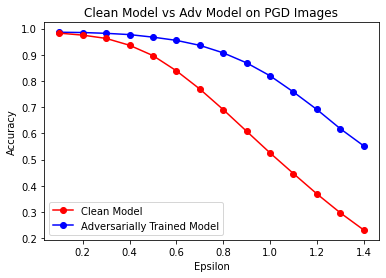

In [5]:
# divide pgd_images and pgd_labels into different epsilon values
epsilon_values = np.arange(0.1, 1.5, 0.1)

# put images into 14 groups of images as a multidiemensional array
pgd_images_grouped = np.array(np.array_split(pgd_images, len(epsilon_values)))
pgd_labels_grouped = np.array(np.array_split(pgd_labels, len(epsilon_values)))

plt.title('Clean Model vs Adv Model on PGD Images')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')

model_adv_pred = []
model_pred = []

# iterate through epsilon values and evaluate model and model_adv for each iteration
for index, epsilon in enumerate(epsilon_values):
    # print('model_adv accuracy on Cleverhans PGD images for ', round(epsilon, 1),' :' , model_adv.evaluate(pgd_images_grouped[index], pgd_labels_grouped[index], verbose=0)[1])
    # print('model accuracy on  Cleverhans PGD images for ', round(epsilon, 1) ,' :' , model.evaluate(pgd_images_grouped[index], pgd_labels_grouped[index], verbose=0)[1])

    model_adv_pred.append(model_adv.evaluate(pgd_images_grouped[index], pgd_labels_grouped[index], verbose=0)[1])
    model_pred.append(model.evaluate(pgd_images_grouped[index], pgd_labels_grouped[index], verbose=0)[1])

model_adv_plot, = plt.plot(epsilon_values, model_adv_pred, color='blue', marker='o', label='Adversarially Trained Model')
model_plot, = plt.plot(epsilon_values, model_pred, color='red', marker='o', label='Clean Model')
plt.legend(handles=[model_plot, model_adv_plot])
plt.show()


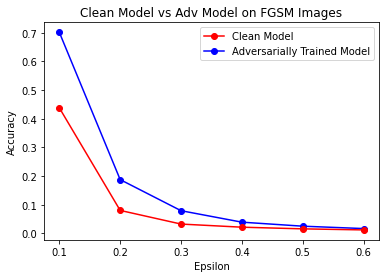

In [9]:
# divide fgsm_images and pgd_labels into different epsilon values
epsilon_values = np.arange(0.1, 1.5, 0.1)
epsilon_values_sliced = np.arange(0.1, 0.7, 0.1)

# put images into 14 groups of images as a multidiemensional array
fgsm_images_grouped = np.array(np.array_split(fgsm_images, len(epsilon_values)))
fgsm_labels_grouped = np.array(np.array_split(fgsm_labels, len(epsilon_values)))

plt.title('Clean Model vs Adv Model on FGSM Images')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')

model_adv_pred = []
model_pred = []

# iterate through epsilon values and evaluate model and model_adv for each iteration
for index, epsilon in enumerate(epsilon_values):
    # print('model_adv accuracy on Cleverhans PGD images for ', round(epsilon, 1),' :' , model_adv.evaluate(fgsm_images_grouped[index], fgsm_labels_grouped[index], verbose=0)[1])
    # print('model accuracy on  Cleverhans PGD images for ', round(epsilon, 1) ,' :' , model.evaluate(fgsm_images_grouped[index], fgsm_labels_grouped[index], verbose=0)[1])
    if epsilon > 0.6:
        break

    model_adv_pred.append(model_adv.evaluate(fgsm_images_grouped[index], fgsm_labels_grouped[index], verbose=0)[1])
    model_pred.append(model.evaluate(fgsm_images_grouped[index], fgsm_labels_grouped[index], verbose=0)[1])

model_adv_plot, = plt.plot(epsilon_values_sliced, model_adv_pred, color='blue', marker='o', label='Adversarially Trained Model')
model_plot, = plt.plot(epsilon_values_sliced, model_pred, color='red', marker='o', label='Clean Model')
plt.legend(handles=[model_plot, model_adv_plot])
plt.show()


In [37]:
# divide fgsm images into train and test sets for adversarial training
fgsm_images_train = fgsm_images[:120000, :]
fgsm_images_test = fgsm_images[120000:, :]
fgsm_labels_train = fgsm_labels[:120000]
fgsm_labels_test = fgsm_labels[120000:]

print('Train set: {}'.format(fgsm_images_train.shape))
print('Test set: {}'.format(fgsm_images_test.shape))
print('Train labels: {}'.format(fgsm_labels_train.shape))
print('Test labels: {}'.format(fgsm_labels_test.shape))

Train set: (120000, 28, 28, 1)
Test set: (20000, 28, 28, 1)
Train labels: (120000, 1)
Test labels: (20000, 1)


In [7]:
model_madry = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10),
])

model_madry.summary()

model_madry.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model_madry.fit(
    x = fgsm_images_train,
    y = fgsm_labels_train,
    epochs=4,
    shuffle=True
)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 128)               692352    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 693,962
Trainable params: 693,962
Non-trainable params: 0
__________________________________________________

In [8]:
model_madry.save('assets/models/mnist_model_madry.h5')

In [4]:
model_madry = tf.keras.models.load_model('assets/models/mnist_model_madry.h5')

In [17]:
print(ds_train_adv_images.shape, fgsm_images_train.shape)
print(ds_train_adv_labels.shape, fgsm_labels_train.shape)

fgsm_labels_train = np.argmax(fgsm_labels_train, axis=1)


ds_train_adv_images_mod = np.concatenate((ds_train_adv_images, fgsm_images_train), axis=0)
ds_train_adv_labels_mod = np.concatenate((ds_train_adv_labels, fgsm_labels_train), axis=0)

print(ds_train_adv_images_mod.shape, ds_train_adv_images_mod.shape)


(126060, 28, 28, 1) (120000, 28, 28, 1)
(126060,) (120000, 1)
(246060, 28, 28, 1) (246060, 28, 28, 1)


In [18]:
# model_adv = tf.keras.models.Sequential([
#   tf.keras.layers.Flatten(input_shape=(28, 28)),
#   tf.keras.layers.Dense(128, activation='relu'),
#   tf.keras.layers.Dense(10)
# ])

model_adv_mod = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10)
])

model_adv_mod.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model_adv_mod.fit(
    x = ds_train_adv_images_mod,
    y = ds_train_adv_labels_mod,
    epochs=6,
    shuffle=True
)

Epoch 1/6
7690/7690 [==============================] - 54s 6ms/step - loss: 0.0589 - sparse_categorical_accuracy: 0.9831
Epoch 2/6
7690/7690 [==============================] - 46s 6ms/step - loss: 0.0186 - sparse_categorical_accuracy: 0.9947: 1s - loss: 0.0187 - sparse
Epoch 3/6
7690/7690 [==============================] - 43s 6ms/step - loss: 0.0113 - sparse_categorical_accuracy: 0.9967
Epoch 4/6
7690/7690 [==============================] - 44s 6ms/step - loss: 0.0074 - sparse_categorical_accuracy: 0.9977
Epoch 5/6
7690/7690 [==============================] - 45s 6ms/step - loss: 0.0050 - sparse_categorical_accuracy: 0.9984
Epoch 6/6
7690/7690 [==============================] - 46s 6ms/step - loss: 0.0038 - sparse_categorical_accuracy: 0.9987


In [18]:
model_adv_mod.save('assets/models/mnist_model_adv_mod.h5')

In [5]:
model_adv_mod = tf.keras.models.load_model('assets/models/mnist_model_adv_mod.h5')

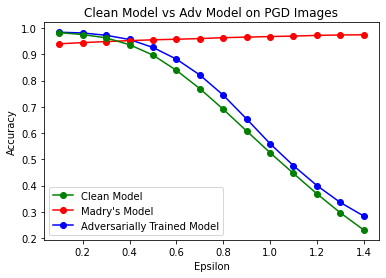

In [42]:
# divide pgd_images and pgd_labels into different epsilon values
epsilon_values = np.arange(0.1, 1.5, 0.1)

# put images into 14 groups of images as a multidiemensional array
pgd_images_grouped = np.array(np.array_split(pgd_images, len(epsilon_values)))
pgd_labels_grouped = np.array(np.array_split(pgd_labels, len(epsilon_values)))

plt.title('Clean Model vs Adv Model on PGD Images')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')

model_adv_pred = []
model_madry_pred = []
model_pred = []

# iterate through epsilon values and evaluate model and model_adv for each iteration
for index, epsilon in enumerate(epsilon_values):
    # print('model_adv accuracy on Cleverhans PGD images for ', round(epsilon, 1),' :' , model_adv.evaluate(pgd_images_grouped[index], pgd_labels_grouped[index], verbose=0)[1])
    # print('model accuracy on  Cleverhans PGD images for ', round(epsilon, 1) ,' :' , model.evaluate(pgd_images_grouped[index], pgd_labels_grouped[index], verbose=0)[1])

    model_adv_pred.append(model_adv_mod.evaluate(pgd_images_grouped[index], pgd_labels_grouped[index], verbose=0)[1])
    model_madry_pred.append(model_madry.evaluate(pgd_images_grouped[index], pgd_labels_grouped[index], verbose=0)[1])
    model_pred.append(model.evaluate(pgd_images_grouped[index], pgd_labels_grouped[index], verbose=0)[1])


model_adv_plot, = plt.plot(epsilon_values, model_adv_pred, color='blue', marker='o', label='Adversarially Trained Model')
model_madry_plot, = plt.plot(epsilon_values, model_madry_pred, color='red', marker='o', label='Madry\'s Model')
model_plot, = plt.plot(epsilon_values, model_pred, color='green', marker='o', label='Clean Model')
plt.legend(handles=[model_plot, model_madry_plot, model_adv_plot])
plt.show()


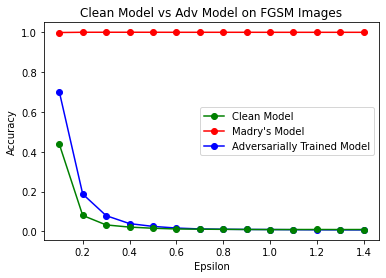

In [7]:
# divide fgsm_images and fgsm_labels into different epsilon values
epsilon_values = np.arange(0.1, 1.5, 0.1)

# put images into 14 groups of images as a multidiemensional array
fgsm_images_grouped = np.array(np.array_split(fgsm_images, len(epsilon_values)))
fgsm_labels_grouped = np.array(np.array_split(fgsm_labels, len(epsilon_values)))

plt.title('Clean Model vs Adv Model on FGSM Images')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')

model_adv_pred = []
model_madry_pred = []
model_pred = []

# iterate through epsilon values and evaluate model and model_adv for each iteration
for index, epsilon in enumerate(epsilon_values):
    # print('model_adv accuracy on Cleverhans FGSM images for ', round(epsilon, 1),' :' , model_adv.evaluate(fgsm_images_grouped[index], fgsm_labels_grouped[index], verbose=0)[1])
    # print('model accuracy on  Cleverhans FGSM images for ', round(epsilon, 1) ,' :' , model.evaluate(fgsm_images_grouped[index], fgsm_labels_grouped[index], verbose=0)[1])

    model_adv_pred.append(model_adv.evaluate(fgsm_images_grouped[index], fgsm_labels_grouped[index], verbose=0)[1])
    model_madry_pred.append(model_madry.evaluate(fgsm_images_grouped[index], fgsm_labels_grouped[index], verbose=0)[1])
    model_pred.append(model.evaluate(fgsm_images_grouped[index], fgsm_labels_grouped[index], verbose=0)[1])


model_adv_plot, = plt.plot(epsilon_values, model_adv_pred, color='blue', marker='o', label='Adversarially Trained Model')
model_madry_plot, = plt.plot(epsilon_values, model_madry_pred, color='red', marker='o', label='Madry\'s Model')
model_plot, = plt.plot(epsilon_values, model_pred, color='green', marker='o', label='Clean Model')
plt.legend(handles=[model_plot, model_madry_plot, model_adv_plot])
plt.show()


In [46]:
model_madry.evaluate(ds_test_images, ds_test_labels)

313/313 [==============================] - 1s 4ms/step - loss: 0.1927 - sparse_categorical_accuracy: 0.9360


[0.19272330403327942, 0.9359999895095825]

In [47]:
model_adv.evaluate(ds_test_images, ds_test_labels)

313/313 [==============================] - 1s 4ms/step - loss: 0.0572 - sparse_categorical_accuracy: 0.9858


[0.05719533562660217, 0.98580002784729]

In [48]:
model.evaluate(ds_test_images, ds_test_labels)

313/313 [==============================] - 2s 5ms/step - loss: 0.0471 - sparse_categorical_accuracy: 0.9850


[0.04714849591255188, 0.9850000143051147]